# TP : Proximal coordinate descent method on regression models

#### Authors: S. Gaiffas, A. Gramfort

## Aim

The aim of this material is to code 
- proximal coordinate descent

for 
- Lasso / L1 linear regression
- non-negative least squares (NNLS)

models.

The proximal operators we will use are the 
- L1 penalization
- indicator function of $\mathbb{R}_+$

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 23th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 17 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "benoît"
ln1 = "choffin"
fn2 = "peter"
ln2 = "martigny"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_cd", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_cd_choffin_benoît_and_martigny_peter.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse positive vectors and simulating data

### Getting sparse coefficients

In [21]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

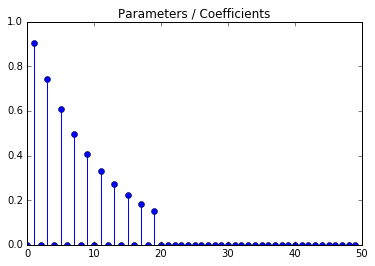

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (idx % 2) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

## Proximal operators and Solver


We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Lasso penalization, where $g(x) = s \|x\|_1$
- Indicator function of $\mathbb{R}_+$, where $g(x) = i_{x \geq 0}(\cdot)$ (this is the convex indicator)

where $s \geq 0$ is a regularization parameter.

We want to minimize:
$$
\arg\min_x F(x)
$$
with
$$
 F(x) = \frac{1}{2} \|b - Ax\|^2 + g(x)
$$

## Questions

- Code a function that computes $g(x)$ and $\text{prox}_g(x)$ for in both cases
- Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions.
- Starting from the code provided in the notebook presented during the coordinate descent course as well as the code below, implement a proximal coordinate method for both penalties.
- Evaluate qualitatively the convergence when varying the conditioning of the problem.
- Bonus: Try to show that coordinate is much less affected by bad conditioning that proximal gradient descent.

### You are expected to implement the smart residuals updates !

### You are very welcome to reuse everything you did for TP1 !

#### Functions to compute g and its proximal function

In [6]:
def lasso(x, s):
    """Value of the Lasso penalization at x with strength t"""
    aux = np.abs(x)
    result = s * np.sum(aux)
    return result

def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""   
    aux = np.abs(x)
    result = np.sign(x) * np.maximum((aux - s*t), 0)
    return result
    
def r_indicator(x, s):
    if min(x) < 0:
        return np.inf
    else:
        return 0
    
def prox_r_indicator(x, s, t=1.):
    temp = np.where(x < 0)
    x[temp] = 0
    return x

The first term of the objective function is convex differentiable and the second term is linearly separable and each $g_i$ is convex. Indeed, for the lasso regularization, we have: $\forall i = 1,...,n \quad g_i(x^{(i)}) = \text{sign}(x^{(i)}) \: (|x^{(i)}| - st)_{+}$ and for the indicator function of $\mathbb{R}_{+}$, we have: $\forall i = 1,...,n \quad g_i(x^{(i)}) = i_{x^{(i)} \geq 0}$.

In [15]:
from numpy.linalg import norm

Let's explain the way we update the "smart residuals", which will show how we update the coefficients after each iteration. At each iteration, we need to compute $x_{k + 1}^{(i)} = \text{prox}_{\gamma_i, g_i}(x_{k}^{(i)} - \gamma_i \nabla_i f(x_k))$. We can rewrite $\nabla_i$ as follows: 
$\nabla_i f(x_k) = A_i^T r_k$, with $r_k = (Ax_k - y)$.
At each iteration, we only need to update the residuals $r_k$ in a smart way, ie considering that we don't have to recompute the whole matrix multiplication. Indeed, we have: $r_{k + 1} = r_k + (x_k^{(i)} - x_s^{(i)}) \; A_i$, where $x_k^{(i)}$ represents the i-th component of $x$ at the k-th iteration, and $s$ is the last iteration before $k$, when $x_i$ had been changed. $A_i$ is the i-th column of $A$.

In [76]:
#We redefine a 1D-proximal operator for the indicator function
def prox_r_indicator_1D(x, s, t=1.):
    if x < 0:
        return 0
    else:
        return x


def cd_linreg(x0, A, b, g, prox_g, s=0., n_iter=50,
              x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm

    Minimize :
    
    1/2 ||b−Ax||^2 + s * g(x)
    
    with coordinate descent.
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, s)
    objectives.append(obj)
    
    Li = np.sum(A * A, axis = 0)
    
    x_new[0] = prox_g(x_new[0] - (1/Li[0])*np.dot(A[:,0].T,np.dot(A,x_new)-b),s=s)
    
    residuals = np.dot(A,x) - b

#     if verbose:
#         print("Lauching Coordinate Descent solver...")
#         print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))

    for k in range(1,n_iter + 1):
        i = k % n_features
        
        alpha = x_new[i-1] - x[i-1]
        residuals = residuals + alpha * A[:,i-1]
        x = x_new.copy()
        
        x_new[i] = prox_g(x_new[i] - (1/Li[i])*np.dot(A[:,i].T,residuals),s=s)
        
        obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
#         if k % 10 == 0 and verbose:
#             print(' | '.join([("%d" % k).rjust(8), 
#                              ("%.2e" % obj).rjust(8), 
#                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [77]:
print(coefs)

[ 0.    0.9   0.    0.74  0.    0.61  0.    0.5   0.    0.41  0.    0.33
  0.    0.27  0.    0.22  0.    0.18  0.    0.15  0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]


### Evaluate qualitatively the convergence when varying the conditioning of the problem.

### Effect of the penalization function

#### LASSO penalization

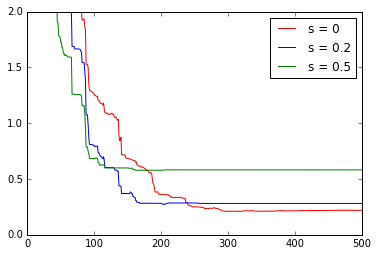

In [80]:
A,b = simu_linreg(coefs = coefs)
x0=np.random.randn(n_features)
plt.figure()
plt.xlim(0, 500)
plt.ylim(0, 2)
plt.plot(cd_linreg(x0=x0,A=A,b=b,g=lasso,prox_g=prox_lasso,n_iter = 5000, s = 0)[2], color = 'r', label = 's = 0')
plt.plot(cd_linreg(x0=x0,A=A,b=b,g=lasso,prox_g=prox_lasso,n_iter = 5000, s = 0.2)[2], color = 'b', label = 's = 0.2')
plt.plot(cd_linreg(x0=x0,A=A,b=b,g=lasso,prox_g=prox_lasso,n_iter = 5000, s = 0.5)[2], color = 'g', label = 's = 0.5')

plt.legend()

We observe that, if we increase the level of penalization $s$, the proximal coordinate descent algorithm converges faster, but the error rate at the limiit is higher. It is normal, because that means that we penalize more the coefficients at each iteration; in the end, their magnitude will be very different from the real value.

#### $\mathbb{R}_+$ penalization

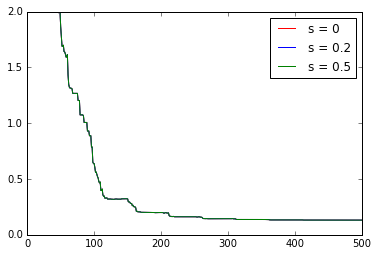

In [81]:
A,b = simu_linreg(coefs = coefs)
x0=np.random.randn(n_features)
plt.figure()
plt.xlim(0, 500)
plt.ylim(0, 2)
plt.plot(cd_linreg(x0=x0,A=A,b=b,g=r_indicator,prox_g=prox_r_indicator_1D,n_iter = 5000, s = 0)[2], color = 'r', label = 's = 0')
plt.plot(cd_linreg(x0=x0,A=A,b=b,g=r_indicator,prox_g=prox_r_indicator_1D,n_iter = 5000, s = 0.2)[2], color = 'b', label = 's = 0.2')
plt.plot(cd_linreg(x0=x0,A=A,b=b,g=r_indicator,prox_g=prox_r_indicator_1D,n_iter = 5000, s = 0.5)[2], color = 'g', label = 's = 0.5')

plt.legend()

In that case, the $s$ has no effect on the convergence speed, which is normal since the proximal function associated does not depend on $s$.

### Effect of the correlation of the features

#### LASSO penalization

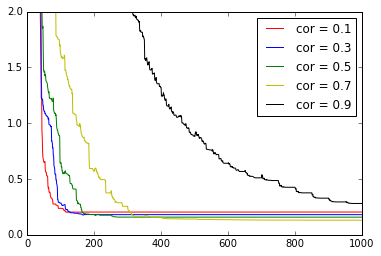

In [94]:
plt.figure()
plt.xlim(0, 1000)
plt.ylim(0, 2)
A,b = simu_linreg(coefs = coefs, corr = 0.1)
x0=np.random.randn(n_features)
plt.plot(cd_linreg(x0=x0,A=A,b=b,g=lasso,prox_g=prox_lasso,n_iter = 5000, s = 0.1)[2], color = 'r', label = 'cor = 0.1')

A,b = simu_linreg(coefs = coefs, corr = 0.3)
x0=np.random.randn(n_features)
plt.plot(cd_linreg(x0=x0,A=A,b=b,g=lasso,prox_g=prox_lasso,n_iter = 5000, s = 0.1)[2], color = 'b', label = 'cor = 0.3')

A,b = simu_linreg(coefs = coefs, corr = 0.5)
x0=np.random.randn(n_features)
plt.plot(cd_linreg(x0=x0,A=A,b=b,g=lasso,prox_g=prox_lasso,n_iter = 5000, s = 0.1)[2], color = 'g', label = 'cor = 0.5')

A,b = simu_linreg(coefs = coefs, corr = 0.7)
x0=np.random.randn(n_features)
plt.plot(cd_linreg(x0=x0,A=A,b=b,g=lasso,prox_g=prox_lasso,n_iter = 5000, s = 0.1)[2], color = 'y', label = 'cor = 0.7')

A,b = simu_linreg(coefs = coefs, corr = 0.9)
x0=np.random.randn(n_features)
plt.plot(cd_linreg(x0=x0,A=A,b=b,g=lasso,prox_g=prox_lasso,n_iter = 5000, s = 0.1)[2], color = 'black', label = 'cor = 0.9')

plt.legend()

We observe that, if we increase the correlation in the features, the convergence speed is lowered. In the meantime, all these algorithms converge approximately to the same value.

#### $\mathbb{R}_+$ penalization

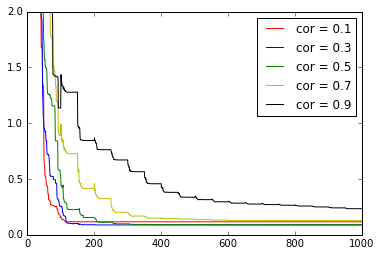

In [95]:
plt.figure()
plt.xlim(0, 1000)
plt.ylim(0, 2)
A,b = simu_linreg(coefs = coefs, corr = 0.1)
x0=np.random.randn(n_features)
plt.plot(cd_linreg(x0=x0,A=A,b=b,g=r_indicator,prox_g=prox_r_indicator_1D,n_iter = 5000, s = 0.1)[2], color = 'r', label = 'cor = 0.1')

A,b = simu_linreg(coefs = coefs, corr = 0.3)
x0=np.random.randn(n_features)
plt.plot(cd_linreg(x0=x0,A=A,b=b,g=r_indicator,prox_g=prox_r_indicator_1D,n_iter = 5000, s = 0.1)[2], color = 'b', label = 'cor = 0.3')

A,b = simu_linreg(coefs = coefs, corr = 0.5)
x0=np.random.randn(n_features)
plt.plot(cd_linreg(x0=x0,A=A,b=b,g=r_indicator,prox_g=prox_r_indicator_1D,n_iter = 5000, s = 0.1)[2], color = 'g', label = 'cor = 0.5')

A,b = simu_linreg(coefs = coefs, corr = 0.7)
x0=np.random.randn(n_features)
plt.plot(cd_linreg(x0=x0,A=A,b=b,g=r_indicator,prox_g=prox_r_indicator_1D,n_iter = 5000, s = 0.1)[2], color = 'y', label = 'cor = 0.7')

A,b = simu_linreg(coefs = coefs, corr = 0.9)
x0=np.random.randn(n_features)
plt.plot(cd_linreg(x0=x0,A=A,b=b,g=r_indicator,prox_g=prox_r_indicator_1D,n_iter = 5000, s = 0.1)[2], color = 'black', label = 'cor = 0.9')

plt.legend()

We observe the same phenomenon with the $\mathbb{R}_+$ penalization.